# Simple Logistic Regression

### Introduction

Consider a random variable $y \in \{0, 1\}$ with $\mathbb{P}\{y = 1\} = p$ and $\mathbb{P}\{y = 0\} = 1 - p$. Here, 1 might indicate the presence of some phenomenon and 0 represents the absence of it. Note that $\mathbb{E}[y] = p$, i.e. the expected outcome of the random variable is captured by this parameter $p$. We would like to explain this probability parameter using some explanatory variables. In this notebook we focus on explanations using one variable.

We assume that $p$ follows the logistic model, i.e. 
\begin{equation*}
p = \frac{\exp(x_0 + x_1a)}{1 + \exp(x_0 + x_1a)},
\end{equation*}

where $a$ is the explanatory variable, $x_0$ and $x_1$ are the model parameters to be set using optimization.

We are given data points:
$\begin{equation*}
\{(a_1, y_1), (a_2, y_2), \ldots, (a_m, y_m)\}
\end{equation*}$

The likelihood function is:
\begin{align*}
\mathcal{L}(x_0, x_1) &= \prod_{i:y_i = 1}p_i\prod_{i: y_i = 0}(1 - p_i)\\
& = \prod_{i: y_i = 1}\frac{\exp(x_0 + x_1a_i)}{1 + \exp(x_0 + x_1a_i)}\prod_{i: y_i = 0}\frac{1}{1 + \exp(x_0 + x_1a_i)}\\
& = \prod_{i=1}^{m}\exp(y_i(x_0 + x_1a_i) - \log(1 + \exp(x_0 + x_1a_i))).
\end{align*}

Thus, we need to find parameters $x_0$ and $x_1$ such that we maximize the likelihood. This is captured in the following optimization problem:

\begin{equation*}
    \max_{x_0, x_1}\prod_{i=1}^{m}\exp(y_i(x_0 + x_1a_i) - \log(1 + \exp(x_0 + x_1a_i))).
\end{equation*}


We can take the negative logarithm and convert the above problem to a minimization one:
\begin{equation*}
    \min_{x_0, x_1} \sum_{i=1}^{m}\log(1 + \exp(x_0 + x_1a_i)) - y_i(x_0 + x_1a_i).
\end{equation*}

### Maximization is equivalent to minimization

Note that maximization and minimization are equivalent: $\arg\max_{x}f(x) = \arg \min_{x}-f(x)$. 

Furthermore, we can also compose the objective function with a monotonically increasing function and the optimum remains the same, i.e. $\arg\max_{x}f(x) = \arg\max_{x}g(f(x))$ where $g$ is monotonically increasing. 

In the following example one can see that minimization of $f(x)$ and maximization of $-\log(f(x))$ would give the same optimum $x^* = 0$.

Such transformations might lead to better numerical performance in practice and therefore this flexibility of optimization is advantageous.

In [1]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
#%matplotlib inline

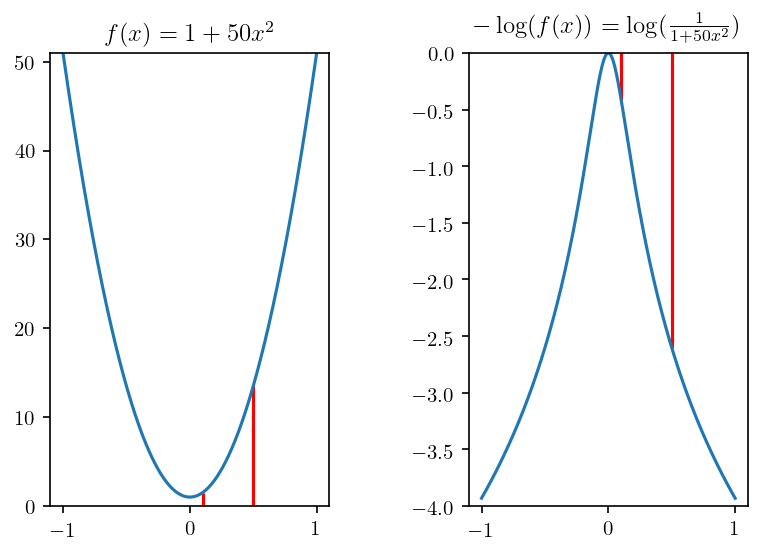

In [2]:
plt.figure(dpi=150)
x_points = np.linspace(-1, 1, 1000)
y_points = 1 + 50*x_points**2
y_points2 = -np.log(y_points)
plt.subplot(121)
plt.plot(x_points, y_points)
plt.vlines(x_points[550], 0, y_points[550], color='red')
plt.vlines(x_points[750], 0, y_points[750], color='red')
plt.ylim([0, 51])
plt.title('$f(x) = 1 + 50x^2$')
plt.subplot(122)
plt.plot(x_points, y_points2)
plt.vlines(x_points[550], 0, y_points2[550], color='red')
plt.vlines(x_points[750], 0, y_points2[750], color='red')
plt.ylim([-4, 0])
plt.title('$-\\log(f(x)) = \\log(\\frac{1}{1 + 50x^2})$')
plt.subplots_adjust(wspace=0.5)

### Before beginning with the main example consider the following toy example, which allows us to visualize how the model parameters $x_0$ and $x_1$ affect the shape of the logistic curve.

In [3]:
@widgets.interact_manual(x0=(-25., 25.), x1=(-35., 35.))
def plot(x0=1, x1=1):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
    t = np.array([0.245, 0.247, 0.356, 0.363, 0.398, 0.409, 0.432, 0.561, 0.569, 0.594, 0.638, 0.656, 0.816, 0.853, 0.938, 1.036, 1.045])
    y_t = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])
    ax.scatter(t[0:9], y_t[0:9], label='Absent', color="blue")
    ax.scatter(t[9:17], y_t[9:17], label='Present', color='black')
    z = np.linspace(0, 1, 1000)
    p_z = np.array([np.exp(x0 + x1*z[i])/(1 + np.exp(x0 + x1*z[i])) for i in range(1000)])
    plt.plot(z, p_z, label='Current Curve', color='red')
    x0_actual = -71
    x1_actual = 125
    p_actual = np.array([np.exp(x0_actual + x1_actual*z[i])/(1 + np.exp(x0_actual + x1_actual*z[i])) for i in range(1000)])
    plt.plot(z, p_actual, label='Optimal Curve', color='green')
    plt.legend(loc=4)
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='x0', max=25.0, min=-25.0), FloatSlider(value=1.0, de…

### Example begins

In this example we consider the study done by Suzuki et al. (2006) where the authors consider the dependence of grain size of beach sand on the presence or absence of an endagered species of spiders. 

For the data, we have the size of the sand grains in mm and 0 denotes the absence of spiders and 1 denotes the presence of spiders.

### Data 

In [4]:
a = np.array([0.245, 0.247, 0.285, 0.299, 0.327, 0.347, 0.356, 0.36, 0.363, 0.364, 0.398, 0.4, 0.409, 0.421, 0.432, 0.473, 0.509, 0.529, 0.561, 0.569, 0.594, 0.638, 0.656, 0.816, 0.853, 0.938, 1.036, 1.045])
y = np.array([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

### Scatter plot the data.  

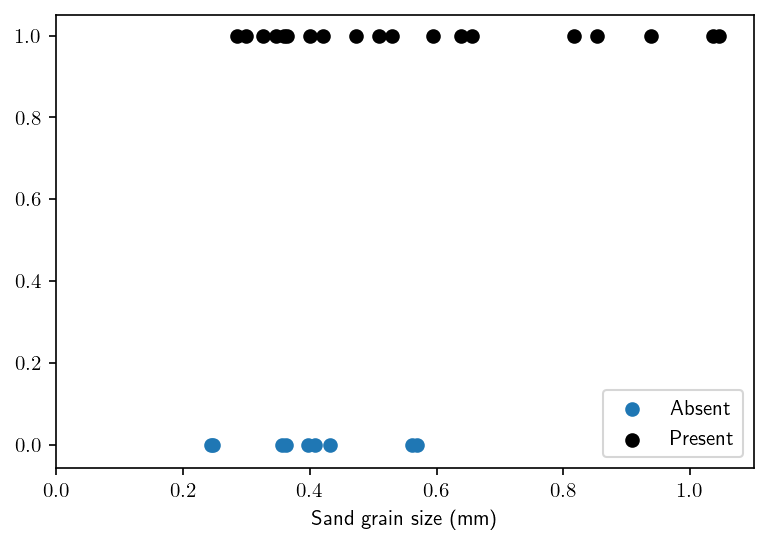

In [5]:
# Do some processing to get decent plots.
m = np.shape(a)[0]
num_ones = np.sum(y)
num_zeros = m - num_ones
a0 = np.zeros(num_zeros)
a1 = np.zeros(num_ones)
y0 = np.zeros(num_zeros)
y1 = np.ones(num_ones)
counter0 = 0
counter1 = 0
for i in range(m):
    if y[i] == 0:
        a0[counter0] = a[i]
        counter0 += 1
    else:
        a1[counter1] = a[i]
        counter1 += 1
        
plt.figure(dpi = 150)
plt.scatter(a0, y0, marker='o', label='Absent')
plt.scatter(a1, y1, marker='o', color='black', label='Present')
plt.xlabel('Sand grain size (mm)')
plt.xlim([0, 1.1])
plt.legend(loc=4)
plt.show()

We now solve the optimization problem using the gradient descent algorithm:
\begin{equation*}
    \min_{x_0, x_1} \sum_{i=1}^{m}\log(1 + \exp(x_0 + x_1a_i)) - y_i(x_0 + x_1a_i).
\end{equation*}

Here's the algorithm for gradient descent with initial guess $x^0$, step size $\alpha$, and stopping condition based on the gradient of $f$:

> **input** $x^0$, $\alpha$, $\epsilon$  
> **set** $k = 0$  
> **while** $\| \nabla f(x^{k}) \| \geq \epsilon$ **do**  
> &nbsp;&nbsp;&nbsp;&nbsp;$x^{k+1} \leftarrow x^k - \alpha \nabla f(x^k)$  
> &nbsp;&nbsp;&nbsp;&nbsp;$k \leftarrow k + 1$  
> **end while**

The gradient of the objective function is 
\begin{equation*}
\nabla f = \begin{bmatrix}
\sum_{i=1}^{m}\frac{\exp(x_0 + x_1a_i)}{1 + \exp(x_0 + x_1a_i)} - y_i\\
\sum_{i=1}^{m}a_i(\frac{\exp(x_0 + x_1a_i)}{1 + \exp(x_0 + x_1a_i)} - y_i)
\end{bmatrix},
\end{equation*}

and is encoded in the following python function.

### We create a python function that returns the gradient of the objective function

In [6]:
def gradF(x):
    """
    input: x = [x_0, x_1]
    output: gradient of the objective function at x
    """
    out = np.zeros(2)
    for i in range(m):
        out[0] += np.exp(x[0] + x[1]*a[i])/(1 + np.exp(x[0] + x[1]*a[i])) - y[i]
        out[1] += a[i]*(np.exp(x[0] + x[1]*a[i])/(1 + np.exp(x[0] + x[1]*a[i])) - y[i])
    return out

### Gradient Descent python implementation

In [7]:
def runGradientDescent(start, alpha, eps):
    """
    input: start (initial guess), alpha (step-size), eps (tolerance)
    output: final (the final estimate of the optimum), counter (number of iterations taken)
    """
    final = start - alpha*gradF(start)
    counter = 0    
    while (np.linalg.norm(gradF(final)) > eps):
        final = final - alpha*gradF(final)
        counter += 1     
    return final, counter

### Run the gradient descent algorithm 

In [8]:
start = np.array([-10, 10]) # initial guess. Other values: np.array([10, 1]), np.array([1, 10]), np.array([-10, 1])
alpha = 0.25 # step size. Other values: 0.3, 0.2, 0.1, 0.05
eps = 5*1e-3 # tolerance. Other values: 1e-2, 1e-4

final, counter = runGradientDescent(start, alpha, eps)

### Final Plot

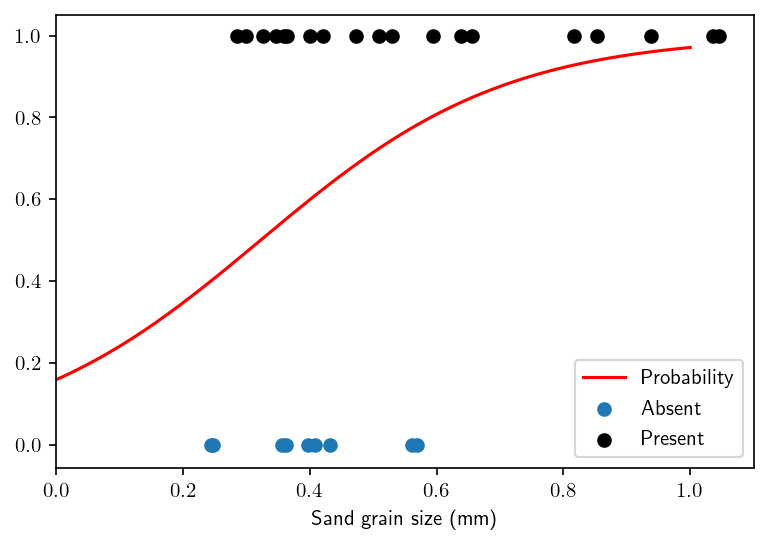

In [9]:
x = np.linspace(0, 1, 1000)
p = np.array([np.exp(final[0] + final[1]*x[i])/(1 + np.exp(final[0] + final[1]*x[i])) for i in range(1000)])
plt.figure(dpi = 150)
plt.scatter(a0, y0, marker='o', label='Absent')
plt.scatter(a1, y1, marker='o', color='black', label='Present')
plt.plot(x, p, color='red', label='Probability')
plt.xlabel('Sand grain size (mm)')
plt.legend(loc=4)
plt.xlim([0, 1.1])
plt.show()

### Experiment:  Step-size versus Objective Value and Step-size versus # of Iterations

In [10]:
def objective(x):
    """
    input: x = [x_0, x_1] 
    output: objective value at the given x
    """
    output = 0
    for i in range(m):
        output += np.log(1 + np.exp(x[0] + x[1]*a[i])) - y[i]*(x[0] + x[1]*a[i])
    return output

In [11]:
# Running gradient descent algorithm for different choices of alpha
alpha_values = np.array([0.3, 0.2, 0.1, 0.05])
objective_values = np.zeros(len(alpha_values))
iteration_values = np.zeros(len(alpha_values))
for i in range(len(alpha_values)):
    alpha = alpha_values[i]
    final, counter = runGradientDescent(start, alpha, eps)
    objective_values[i] = objective(final)
    iteration_values[i] = counter

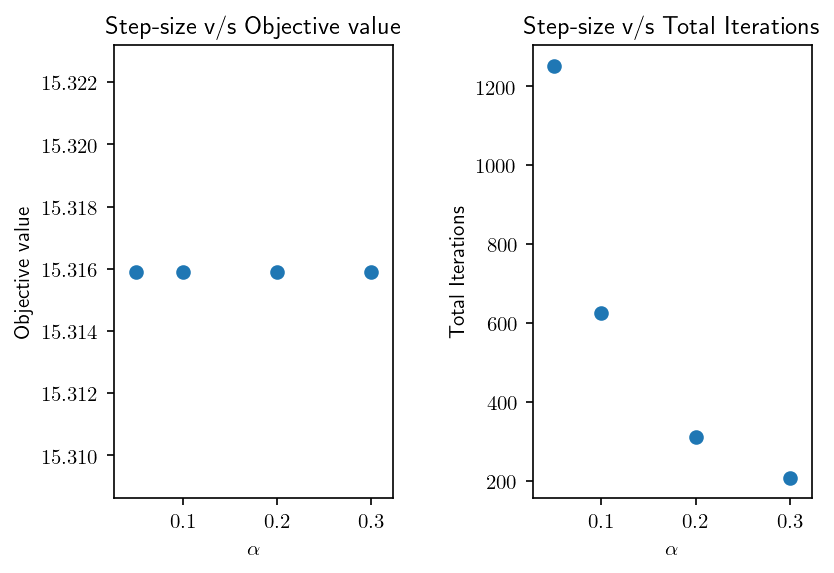

In [12]:
plt.figure(dpi = 150)
plt.subplot(121)
plt.scatter(alpha_values, objective_values)
plt.xlabel('$\\alpha$')
plt.ylabel('Objective value')
plt.title('Step-size v/s Objective value')
plt.subplot(122)
plt.scatter(alpha_values, iteration_values)
plt.xlabel('$\\alpha$')
plt.ylabel('Total Iterations')
plt.title('Step-size v/s Total Iterations')
plt.subplots_adjust(wspace=0.5)

### Exercise

There are three parameters: $x_0$, $\alpha$ and $\epsilon$. Keep two constant and change the other one and see the effect on the time taken to run the algorithm. 

In the experiment above, varying $\alpha$ has already been done for you. 
Note: If you choose $\alpha > 0.4$ and run the experiment, then the algorithm does not converge because step sizes above this threshold are bad in the sense that a step of gradient descent doesn't decrease the objective value.

Also, replot the figure below to see if final curve looks reasonable.

### Penalized Logistic Regression 

We add a $L_2$-regularization term to the objective of the optimization problem considered above. Explicitly we now solve:

\begin{equation*}
    \min_{x_0, x_1} (\sum_{i=1}^{m}\log(1 + \exp(x_0 + x_1a_i)) - y_i(x_0 + x_1a_i)) + \frac{\lambda}{2}(x_0^2 + x_1^2) .
\end{equation*}

The gradient of this new objective function is 
\begin{equation*}
\nabla f = \begin{bmatrix}
\sum_{i=1}^{m}(\frac{\exp(x_0 + x_1a_i)}{1 + \exp(x_0 + x_1a_i)} - y_i) + \lambda x_0\\
\sum_{i=1}^{m}a_i(\frac{\exp(x_0 + x_1a_i)}{1 + \exp(x_0 + x_1a_i)} - y_i) + \lambda x_1
\end{bmatrix},
\end{equation*}

and is encoded in the following python function.

### Python function which returns the gradient 

In [13]:
def gradF_pen(x, lamda):
    out = np.zeros(2)
    for i in range(m):
        out[0] += np.exp(x[0] + x[1]*a[i])/(1 + np.exp(x[0] + x[1]*a[i])) - y[i]
        out[1] += a[i]*(np.exp(x[0] + x[1]*a[i])/(1 + np.exp(x[0] + x[1]*a[i])) - y[i])
    out[0] += lamda*x[0]
    out[1] += lamda*x[1]
    return out

### Gradient descent implementation for penalized objective

In [14]:
def runGD_penalized(start_pen, alpha_pen, eps_pen, lamda):
    final_pen = start_pen - alpha_pen*gradF_pen(start_pen, lamda)
    counter_pen = 0
    while (np.linalg.norm(gradF_pen(final_pen, lamda)) > eps_pen):
        final_pen = final_pen - alpha_pen*gradF_pen(final_pen, lamda)
        counter_pen += 1
    return final_pen, counter_pen

### Run the gradient descent algorithm

In [15]:
start_pen = np.array([-10, 10]) # initial guess. Other values: np.array([10, 1]), np.array([1, 10]), np.array([-10, 1])
alpha_pen = 0.15 # step size. Other values: 0. 0.01 , 0.1
lamda = 0.1 # Regularization term
eps_pen = 5*1e-3 # tolerance. Other values 1e-2, 1e-4, 1e-5

final_pen, counter_pen = runGD_penalized(start_pen, alpha_pen, eps_pen, lamda)

### Compare Logistic Regression to Penalized Logistic Regression

In [20]:
@widgets.interact_manual(lamda=(0.0005, 4.50))
def plot(lamda=0.1):
    # Run the algorithm
    final_pen, counter_pen = runGD_penalized(start_pen, alpha_pen, eps_pen, lamda)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
    x = np.linspace(0, 1, 1000)
    p = np.array([np.exp(final[0] + final[1]*x[i])/(1 + np.exp(final[0] + final[1]*x[i])) for i in range(1000)])
    p_pen = np.array([np.exp(final_pen[0] + final_pen[1]*x[i])/(1 + np.exp(final_pen[0] + final_pen[1]*x[i])) for i in range(1000)])
    
    plt.scatter(a0, y0, marker='o', label='Absent')
    plt.scatter(a1, y1, marker='o', color='black', label='Present')
    plt.plot(x, p, color='red', linestyle='--', label='Logistic Reg.')
    plt.plot(x, p_pen, color='blue', label='Pen. Logistic Reg.')
    plt.xlabel('Sand grain size (mm)')
    plt.legend(loc=4)
    plt.xlim([0, 1.1])
    plt.show()
    

interactive(children=(FloatSlider(value=0.1, description='lamda', max=4.5, min=0.0005), Button(description='Ru…

### Exercise
Vary the hyperparameter $\lambda$ in $[0, 0.5]$ and observe how the penalized logistic regression curve changes

**Reference**: *Suzuki, S., N. Tsurusaki, and Y. Kodama. 2006. Distribution of an endangered burrowing spider Lycosa ishikariana in the San'in Coast of Honshu, Japan (Araneae: Lycosidae). Acta Arachnologica 55: 79-86.*